In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
data_list_img = pd.read_csv("../../Results/AE_tif_mixed_bright/image_list.csv", index_col=0)
data_AE = pd.read_csv("../../Results/AE_tif_mixed_bright/metrics_AE.csv", index_col=0)

In [3]:
PREDICTION_ITERATION=1
data = data_AE.merge(data_list_img, on="Image_path")
data = data[data["prediction_interation"]==PREDICTION_ITERATION]

data.columns

Index(['normalization', 'standardization', 'image_type', 'channel_image',
       'image_resize_x', 'image_resize_y', 'Image_path', 'autoencoder_name',
       'prediction_interation', 'prediction_size', 'gini_pxl_space',
       'kurtois_pxl_space', 'entropy_pxl_space', 'gini_latent_space',
       'kurtois_latent_space', 'entropy_latent_space',
       'mean_activation_latent_space', 'MSE_compared_to_start',
       'latent_distance_to_start', 'SSIM_compared_to_start',
       'MSE_compared_to_previous_step', 'latent_distance_to_previous_step',
       'SSIM_compared_to_previous_step', 'filename', 'type', 'folder',
       'habitat', 'color_control', 'tv_loss', 'layers', 'sex', 'fish_n',
       'species', 'img_width', 'img_height', 'image_extension'],
      dtype='object')

remove annoying values

In [4]:
#drop badly annotated sex
a=len(data)
data = data[data["sex"]!="0"]
#drop unrecognized habitats
data = data[data["habitat"]!="not_listed"]
print("dropped ", a-len(data))

dropped  90


In [5]:
data.head(3)

,normalization,standardization,image_type,channel_image,image_resize_x,image_resize_y,Image_path,autoencoder_name,prediction_interation,prediction_size,...,habitat,color_control,tv_loss,layers,sex,fish_n,species,img_width,img_height,image_extension
4001,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/z...,ConvolutionnalModelTrained_Bedrock240_LD6_pred...,1.0,128.0,...,sand,NaN,NaN,NaN,F,7.0,zonistium,6451,2461,.jpg
4051,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/z...,ConvolutionnalModelTrained_Boulder240_LD6_pred...,1.0,128.0,...,sand,NaN,NaN,NaN,F,7.0,zonistium,6451,2461,.jpg
4101,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/z...,ConvolutionnalModelTrained_Detritus240_LD6_pre...,1.0,128.0,...,sand,NaN,NaN,NaN,F,7.0,zonistium,6451,2461,.jpg


Normalize the values per network and per sex

In [6]:
columns_values = [
                  "gini_latent_space", "kurtois_latent_space", "mean_activation_latent_space", 
                #"entropy_latent_space", "SSIM_compared_to_start",
                  "MSE_compared_to_start",
                 ]

In [7]:
norm_data  = data
norm_data[columns_values] = data.groupby(['sex','autoencoder_name'])[columns_values].transform(lambda x: (x - x.mean()) / x.std())

In [8]:
norm_data.head(3)

,normalization,standardization,image_type,channel_image,image_resize_x,image_resize_y,Image_path,autoencoder_name,prediction_interation,prediction_size,...,habitat,color_control,tv_loss,layers,sex,fish_n,species,img_width,img_height,image_extension
4001,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/z...,ConvolutionnalModelTrained_Bedrock240_LD6_pred...,1.0,128.0,...,sand,NaN,NaN,NaN,F,7.0,zonistium,6451,2461,.jpg
4051,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/z...,ConvolutionnalModelTrained_Boulder240_LD6_pred...,1.0,128.0,...,sand,NaN,NaN,NaN,F,7.0,zonistium,6451,2461,.jpg
4101,True,True,RGB,ALL,NaN,NaN,/home/durrmeyer/Images/Poissons/JPEG Cropped/z...,ConvolutionnalModelTrained_Detritus240_LD6_pre...,1.0,128.0,...,sand,NaN,NaN,NaN,F,7.0,zonistium,6451,2461,.jpg


In [9]:
norm_data.columns

Index(['normalization', 'standardization', 'image_type', 'channel_image',
       'image_resize_x', 'image_resize_y', 'Image_path', 'autoencoder_name',
       'prediction_interation', 'prediction_size', 'gini_pxl_space',
       'kurtois_pxl_space', 'entropy_pxl_space', 'gini_latent_space',
       'kurtois_latent_space', 'entropy_latent_space',
       'mean_activation_latent_space', 'MSE_compared_to_start',
       'latent_distance_to_start', 'SSIM_compared_to_start',
       'MSE_compared_to_previous_step', 'latent_distance_to_previous_step',
       'SSIM_compared_to_previous_step', 'filename', 'type', 'folder',
       'habitat', 'color_control', 'tv_loss', 'layers', 'sex', 'fish_n',
       'species', 'img_width', 'img_height', 'image_extension'],
      dtype='object')

ADD the columns 1 if from the same habitat else 0 

In [10]:
def isSameHabitat(serie):
    if serie["habitat"] in serie["autoencoder_name"].lower():
        return pd.Series([1], index=["same_env"])
    else:
        return pd.Series([0], index=["same_env"])

col_var_explicative = norm_data[["habitat", "autoencoder_name"]].apply(isSameHabitat, axis=1)
counts = col_var_explicative.value_counts()
print(np.array(counts)[0]+np.array(counts)[1])
counts

1955


same_env
0           1564
1            391
dtype: int64

In [11]:
norm_data["habitat"].value_counts()

sand        545
detritus    475
bedrock     420
gravel      365
boulder     150
Name: habitat, dtype: int64

Calculate the accuray if the prediction is always 0

In [12]:
counts = np.array(counts)
pred0 = counts[0]+counts[1]
tot = counts[0]+counts[1]

TP= 0
TN= counts[0]
FP= 0
FN= counts[1]
print(TP, TN, FP, FN)
bad_acc = (TP + TN)/(TP + TN + FP + FN)
print(bad_acc)

0 1564 0 391
0.8


If I only predict 0s I'll have an accuracy of 

In [13]:
ext_data = pd.concat([norm_data, col_var_explicative], axis=1)

In [31]:
columns_needed = ["Image_path", "autoencoder_name", "habitat", "same_env", *columns_values]

data_male = ext_data[ext_data["sex"]=="M"][columns_needed]
data_female = ext_data[ext_data["sex"]=="F"][columns_needed]
data_female.to_csv("female.csv")
data_male.to_csv("male.csv")

In [15]:
data_male.columns

Index(['Image_path', 'autoencoder_name', 'habitat', 'same_env',
       'gini_latent_space', 'kurtois_latent_space',
       'mean_activation_latent_space', 'MSE_compared_to_start'],
      dtype='object')

<AxesSubplot:>

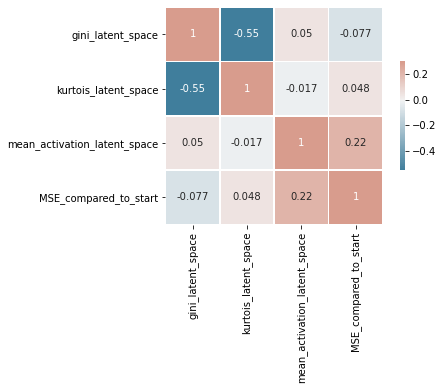

In [16]:
corr_male = data_male[columns_values].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_male, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

<AxesSubplot:>

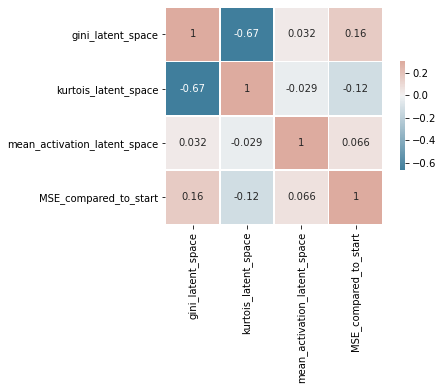

In [17]:
corr_female = data_female[columns_values].corr()

sns.heatmap(corr_female, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [18]:
from sklearn.linear_model import LogisticRegression

# GINI LATENT

In [51]:
def regression(data, variable, title="", stat="probability", common_norm=False):
    X = data[variable].to_numpy().reshape(-1, 1)
    y = data["same_env"]
    print("mean 0: ",round(np.mean(X[y==0]), 4), " // std 0: ", round(np.std(X[y==0]) ,4), " // count 0: ", len(X[y==0]))
    print("mean 1: ",round(np.mean(X[y==1]), 4), " // std 1: ", round(np.std(X[y==1]) ,4), " // count 1: ", len(X[y==1]))
    reg = LogisticRegression().fit(X, y)
    print("accuracy score of the logistic regression: {} , bad accuracy at {}".format(
        round(reg.score(X, y), 4), round(bad_acc, 4)))
    sns.histplot(data=data, x=variable, hue="same_env", kde=True, stat=stat, common_norm=common_norm).set_title(title)
    plt.show()

mean 0:  -0.0121  // std 0:  1.0014  // count 0:  828
mean 1:  0.0484  // std 1:  0.9805  // count 1:  207
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


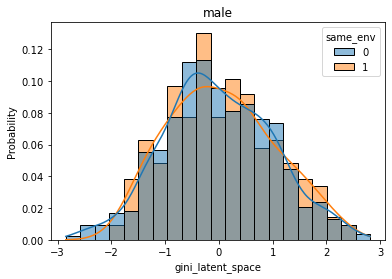

mean 0:  0.0179  // std 0:  0.9956  // count 0:  736
mean 1:  -0.0718  // std 1:  1.0008  // count 1:  184
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


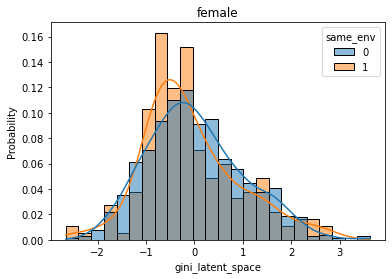

In [53]:
%matplotlib inline
regression(data_male, "gini_latent_space", title="male")
regression(data_female, "gini_latent_space", title="female")

# Kurtosis Latent

mean 0:  -0.0075  // std 0:  0.9722  // count 0:  828
mean 1:  0.0299  // std 1:  1.0928  // count 1:  207
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


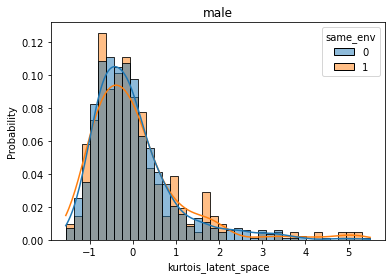

mean 0:  0.0016  // std 0:  0.9765  // count 0:  736
mean 1:  -0.0063  // std 1:  1.0762  // count 1:  184
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


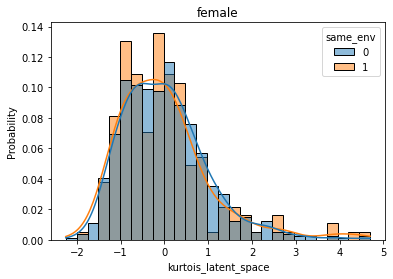

In [54]:
regression(data_male, "kurtois_latent_space", title="male")
regression(data_female, "kurtois_latent_space", title="female")

# Difference MSE

mean 0:  0.033  // std 0:  1.0323  // count 0:  828
mean 1:  -0.1319  // std 1:  0.8315  // count 1:  207
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


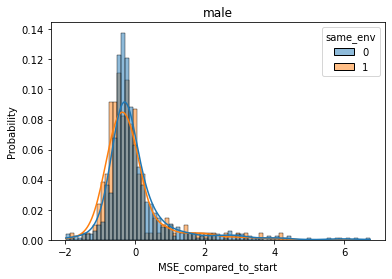

mean 0:  -0.0303  // std 0:  0.9831  // count 0:  736
mean 1:  0.1211  // std 1:  1.0433  // count 1:  184
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


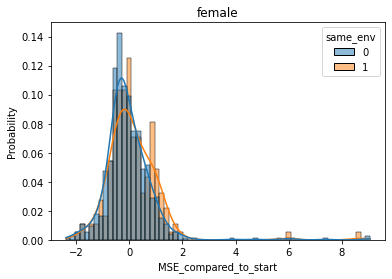

In [55]:
regression(data_male, "MSE_compared_to_start", title="male")
regression(data_female, "MSE_compared_to_start", title="female")

# Mean Latent

mean 0:  0.0581  // std 0:  1.0181  // count 0:  828
mean 1:  -0.2324  // std 1:  0.8729  // count 1:  207
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


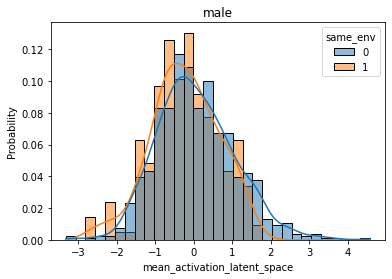

mean 0:  0.0962  // std 0:  0.952  // count 0:  736
mean 1:  -0.3849  // std 1:  1.0783  // count 1:  184
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


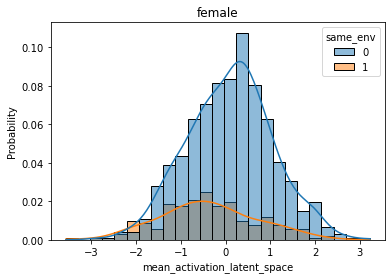

In [56]:
%matplotlib inline
regression(data_male, "mean_activation_latent_space", title="male")
regression(data_female, "mean_activation_latent_space", title="female", stat="probability", common_norm=True)

# Visualization of multiple params

In [57]:
%matplotlib qt
def do_multi_reg(data, params):
    X = data[params]
    y = data["same_env"]
    reg = LogisticRegression().fit(X, y)
    print("accuracy score of the logistic regression: {} , bad accuracy at {}".format(
        round(reg.score(X, y), 4), round(bad_acc, 4)))

def plot_multi_regression(data, params, title=""):
    # generate data    
    n = 200
    x = data[params[0]]
    y = data[params[1]]
    z = data[params[2]]

    # axes instance
    fig = plt.figure(figsize=(6,6))
    fig.suptitle(title)
    ax = Axes3D(fig)

    # get colormap from seaborn
    cmap = ListedColormap(sns.color_palette("tab10", 256).as_hex())
    # plot
    sc = ax.scatter(x, y, z, s=40, c=data["same_env"], marker='o', cmap=cmap, alpha=0.8)
    ax.set_xlabel(params[0])
    ax.set_ylabel(params[1])
    ax.set_zlabel(params[2])

    plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()
    #regression
    do_multi_reg(data, params)

In [25]:
grp = ["mean_activation_latent_space", "MSE_compared_to_start", "kurtois_latent_space"]
plot_multi_regression(data_male, grp, "male")
plot_multi_regression(data_female, grp, "female")

accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8
accuracy score of the logistic regression: 0.7978 , bad accuracy at 0.8


In [26]:
grp = ["mean_activation_latent_space", "MSE_compared_to_start", "gini_latent_space"]
plot_multi_regression(data_male, grp, "male")
plot_multi_regression(data_female, grp, "female")

accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8
accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8


# TOTAL LOGISTIC REGRESSION

In [27]:
do_multi_reg(data_male, columns_values)

accuracy score of the logistic regression: 0.8 , bad accuracy at 0.8
